# 🧠 DBSI-Optimized: Tutorial Notebook

**Diffusion Basis Spectrum Imaging - High Performance Implementation**

Questo notebook ti guida nell'utilizzo della toolbox DBSI-Optimized.

---

## 1. Data Loading



In [1]:
import dbsi_optimized
import numpy as np
import matplotlib.pyplot as plt
from dbsi_optimized.preprocessing import load_dwi_data

dwi_file='/Users/francescoguarnaccia/Desktop/Data/DWI Project/DWI Trials/DWI_data_trials/000019/20250325/prep/DWITE106P2sense19nsoppyAPP_preprocessed_N4.nii.gz'
bvec_file='/Users/francescoguarnaccia/Desktop/Data/DWI Project/DWI Trials/DWI_data_trials/000019/20250325/prep/DWITE106P2sense19nsoppyAPP_corrected.bvec'
bval_file='/Users/francescoguarnaccia/Desktop/Data/DWI Project/DWI Trials/DWI_data_trials/000019/20250325/prep/DWITE106P2sense19nsoppyAPP_corrected.bval'
mask_file='/Users/francescoguarnaccia/Desktop/Data/DWI Project/DWI Trials/DWI_data_trials/000019/20250325/prep/DWITE106P2sense19nsoppyAPP_preprocessed_brain_mask.nii.gz'

dwi, bvals, bvecs, mask, affine = load_dwi_data(dwi_file, bval_file, bvec_file, mask_file)

Loading DWI: /Users/francescoguarnaccia/Desktop/Data/DWI Project/DWI Trials/DWI_data_trials/000019/20250325/prep/DWITE106P2sense19nsoppyAPP_preprocessed_N4.nii.gz
  ✓ Shape: (112, 112, 78, 92)
Loading gradients: /Users/francescoguarnaccia/Desktop/Data/DWI Project/DWI Trials/DWI_data_trials/000019/20250325/prep/DWITE106P2sense19nsoppyAPP_corrected.bval, /Users/francescoguarnaccia/Desktop/Data/DWI Project/DWI Trials/DWI_data_trials/000019/20250325/prep/DWITE106P2sense19nsoppyAPP_corrected.bvec
  ✓ Protocol Summary (92 volumes total):
    - b=0: 9 volumes
    - b=300: 3 volumes
    - b=700: 12 volumes
    - b=1000: 20 volumes
    - b=2000: 48 volumes
Loading mask: /Users/francescoguarnaccia/Desktop/Data/DWI Project/DWI Trials/DWI_data_trials/000019/20250325/prep/DWITE106P2sense19nsoppyAPP_preprocessed_brain_mask.nii.gz
  ✓ Brain voxels: 153,512



---
## 3. SNR estimation + model parameters calibration

Based on the estimated SNR, calibration of Number of isotropic bases and Regularization is performed:

SNR Estimation...

 SNR final: 20.39
 Method: temporal

🚀 Starting Hyperparameter Optimization (SNR: 20.4)...
   Simulating 1000 voxels for 30 configurations.
   Random seed: 42 (Reproducible)
   Generating synthetic dataset: COMPLETED.

Bases  | Lambda | Est      | GT       | MAE      | MSE      | Bias     | Std     
---------------------------------------------------------------------------
100    | 0.50   | 0.1773   | 0.2983   | 0.1230   | 0.0202   | -0.1210  | 0.0743  
100    | 1.00   | 0.1840   | 0.2983   | 0.1173   | 0.0189   | -0.1143  | 0.0762  
100    | 2.00   | 0.1853   | 0.2983   | 0.1162   | 0.0185   | -0.1130  | 0.0759  
100    | 3.00   | 0.1818   | 0.2983   | 0.1192   | 0.0192   | -0.1165  | 0.0751  
100    | 4.00   | 0.1772   | 0.2983   | 0.1231   | 0.0201   | -0.1211  | 0.0738  
100    | 5.00   | 0.1727   | 0.2983   | 0.1270   | 0.0209   | -0.1256  | 0.0717  
150    | 0.50   | 0.1764   | 0.2983   | 0.1237   | 0.0203   | -0.1220  | 0.0737  
150    | 1.00   | 0.1841   | 0

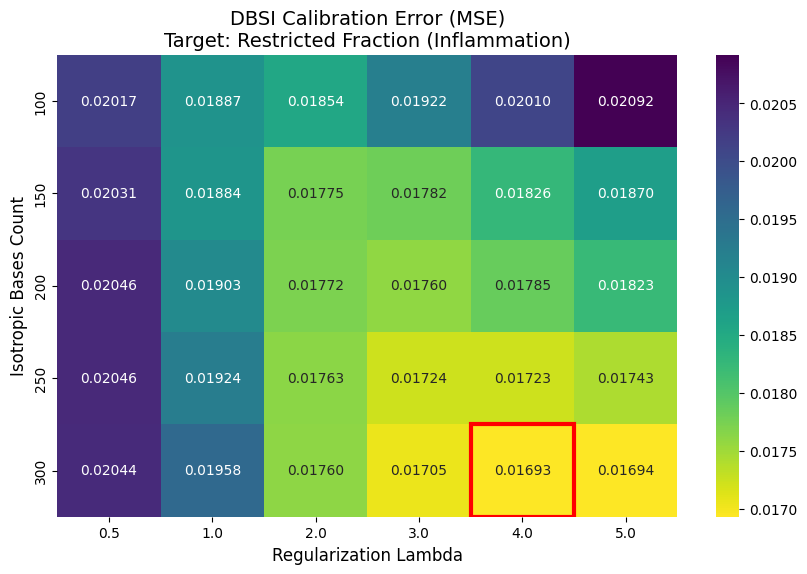


 Desing Matrix Visual Inspection:


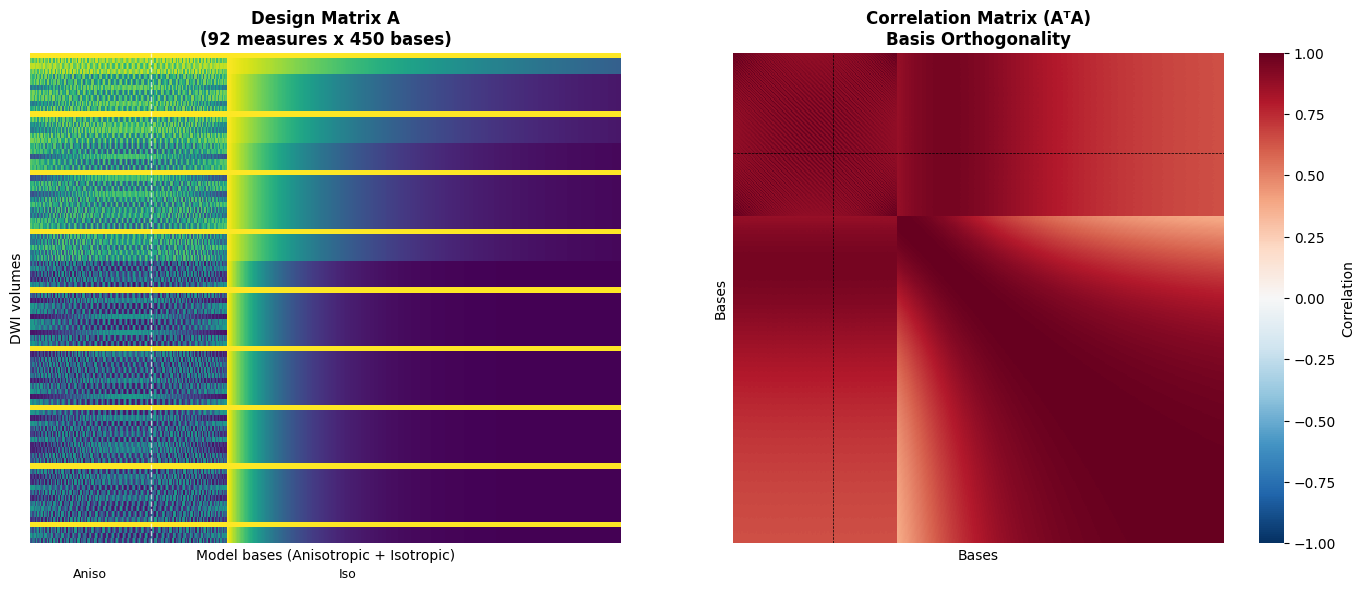

📊 Matrix Info:
   Shape: (92, 450)
   Condition Number: 3.79e+17
   ⚠️ Warning: Ill-conditioned matrix! Regularization is essential.


In [ ]:
from dbsi_optimized import DBSI_FastModel, estimate_snr_robust
from dbsi_optimized.calibration import run_hyperparameter_optimization

print("SNR Estimation...\n")

snr_result = estimate_snr_robust(dwi, bvals, mask)

print(f" SNR final: {snr_result['snr']:.2f}")
print(f" Method: {snr_result['method_used']}")


opt_params = run_hyperparameter_optimization(
    bvals=bvals,
    bvecs=bvecs,
    snr=snr_result['snr'],
    seed=42, #fixed seed for reproducibility
    plot=True
)

from dbsi_optimized import plot_design_matrix

print("\n Desing Matrix Visual Inspection:")

plot_design_matrix(
    bvals=bvals,
    bvecs=bvecs,
    n_iso_bases=opt_params['best_n_bases']
)

print(" DBSI model fitting...")

# Inizializza il modello con i parametri calibrati
model = DBSI_FastModel(
    n_iso_bases=opt_params['best_n_bases'], 
    reg_lambda=opt_params['best_lambda'],   
    verbose=True
)

results = model.fit(dwi, bvals, bvecs, mask)

# Salva i risultati
output_dir = "dbsi_results"
results.save(output_dir, affine=affine)

print(f"\n Results saved in '{output_dir}/'")

---
## 4. Fitting DBSI

DBSI model fitting:

In [ ]:
# Fit Quality check
quality = results.get_quality_summary()

print("\n Quality summary:")
print(f" R² mean: {quality['mean_r_squared']:.3f}")
print(f" R² median: {quality['median_r_squared']:.3f}")
print(f" Fiber fraction mean: {quality['mean_fiber_fraction']:.3f}")
print(f" Restricted fraction mean: {quality['mean_restricted_fraction']:.3f}")